In [2]:
!pip install dadaptation

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dadaptation: filename=dadaptation-3.2-py3-none-any.whl size=23211 sha256=fee5d2a5f6f3fdba35964748e458052c27f32cad6b0a85d685f12a8cf9c730da
  Stored in directory: /root/.cache/pip/wheels/d0/03/6d/feba04df15ef39d9ac4e3504058ac2a88fb2ef9183ba92b111
Successfully built dadaptation


In [3]:
from dadaptation.dadapt_adagrad import DAdaptAdaGrad
from dadaptation.dadapt_adam import DAdaptAdam
from dadaptation.dadapt_sgd import DAdaptSGD
from dadaptation.dadapt_adan import DAdaptAdan
from dadaptation.dadapt_lion import DAdaptLion


Running optimization with d0=1e-08


<ipython-input-5-ca452184c690>:63: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-5-ca452184c690>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enable mixed precision without device_type argument


d0=1e-08, Epoch [1/50], Loss: 0.9792, Accuracy: 70.83%
d0=1e-08, Epoch [2/50], Loss: 0.9819, Accuracy: 70.83%
d0=1e-08, Epoch [3/50], Loss: 0.9839, Accuracy: 70.83%
d0=1e-08, Epoch [4/50], Loss: 0.9826, Accuracy: 70.83%
d0=1e-08, Epoch [5/50], Loss: 0.9858, Accuracy: 70.83%
d0=1e-08, Epoch [6/50], Loss: 0.9799, Accuracy: 70.83%
d0=1e-08, Epoch [7/50], Loss: 0.9789, Accuracy: 70.83%
d0=1e-08, Epoch [8/50], Loss: 0.9826, Accuracy: 70.83%
d0=1e-08, Epoch [9/50], Loss: 0.9814, Accuracy: 70.83%
d0=1e-08, Epoch [10/50], Loss: 0.9754, Accuracy: 70.83%
d0=1e-08, Epoch [11/50], Loss: 0.9798, Accuracy: 70.83%
d0=1e-08, Epoch [12/50], Loss: 0.9820, Accuracy: 70.83%
d0=1e-08, Epoch [13/50], Loss: 0.9791, Accuracy: 70.83%
d0=1e-08, Epoch [14/50], Loss: 0.9813, Accuracy: 70.83%
d0=1e-08, Epoch [15/50], Loss: 0.9803, Accuracy: 70.83%
d0=1e-08, Epoch [16/50], Loss: 0.9800, Accuracy: 70.83%
d0=1e-08, Epoch [17/50], Loss: 0.9778, Accuracy: 70.83%
d0=1e-08, Epoch [18/50], Loss: 0.9805, Accuracy: 70.83%
d

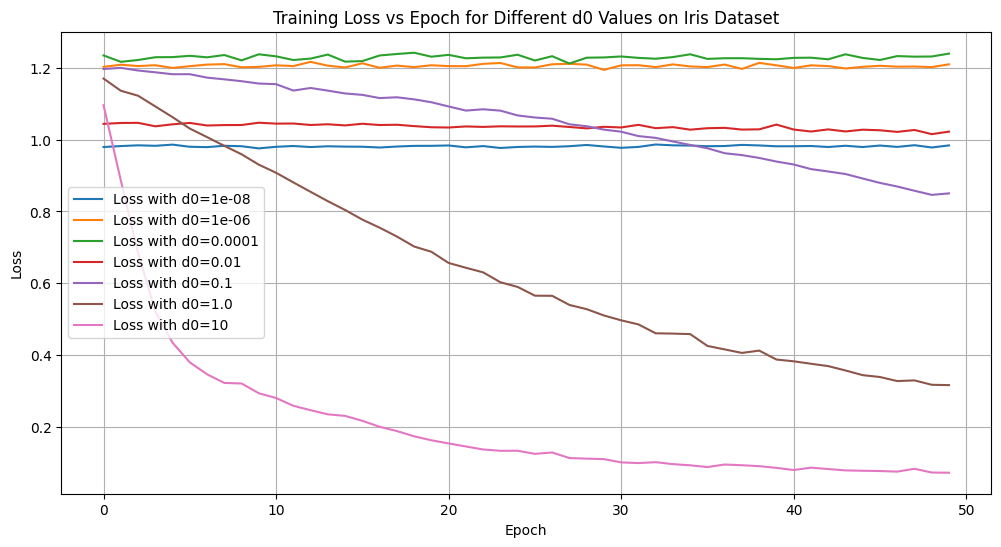

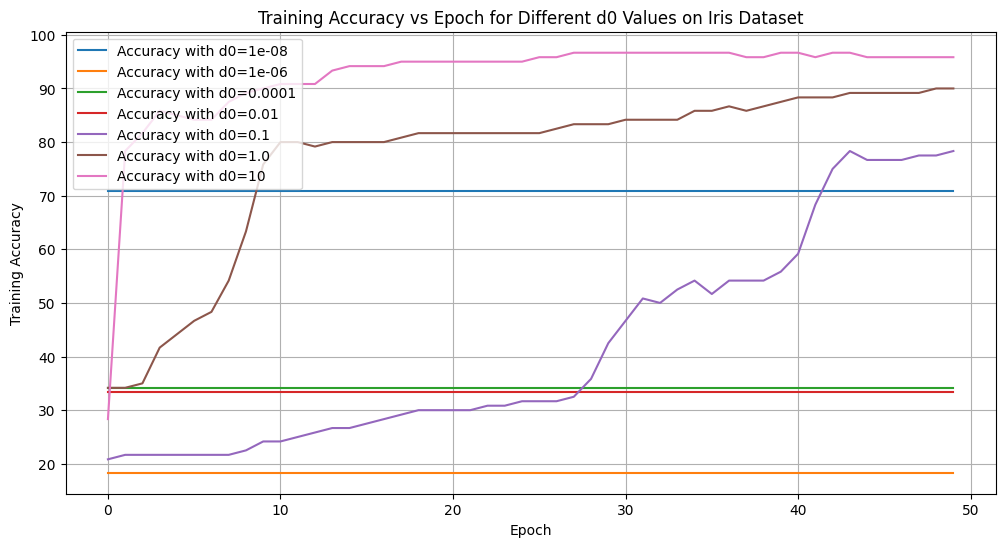

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# Define available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and preprocess the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define a simple neural network for the Iris dataset
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Model, criterion, and training function
model = SimpleNN(input_size=4, hidden_size=16, num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()

# Function to train model with specific d0
# Function to train model with specific d0
def train_with_d0(d0, epochs=50):
    # Re-initialize model parameters to start fresh for each d0
    model.apply(lambda m: m.reset_parameters() if hasattr(m, "reset_parameters") else None)
    optimizer = DAdaptSGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4, d0=d0)

    scaler = torch.cuda.amp.GradScaler()
    train_losses = []
    train_accs = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():  # Enable mixed precision without device_type argument
                outputs = model(features)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        train_acc = 100 * correct / total

        train_losses.append(avg_loss)
        train_accs.append(train_acc)

        # Print and log training status for each d0
        print(f'd0={d0}, Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {train_acc:.2f}%')

    return train_losses, train_accs


# Run experiments with different d0 values
d0_values = [1e-8, 1e-6, 1e-4, 1e-2, 0.1, 1.0, 10]
all_train_losses = []
all_train_accs = []

for d0 in d0_values:
    print(f"\nRunning optimization with d0={d0}")
    train_losses, train_accs = train_with_d0(d0, epochs=50)
    all_train_losses.append(train_losses)
    all_train_accs.append(train_accs)

# Plot loss vs epoch for all d0 values
plt.figure(figsize=(12, 6))
for i, d0 in enumerate(d0_values):
    plt.plot(all_train_losses[i], label=f'Loss with d0={d0}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch for Different d0 Values on Iris Dataset')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy vs epoch for all d0 values
plt.figure(figsize=(12, 6))
for i, d0 in enumerate(d0_values):
    plt.plot(all_train_accs[i], label=f'Accuracy with d0={d0}')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs Epoch for Different d0 Values on Iris Dataset')
plt.legend()
plt.grid(True)
plt.show()


Epoch [1/50], Loss: 1.1815, Accuracy: 30.00%
Epoch [2/50], Loss: 0.7675, Accuracy: 89.17%
Epoch [3/50], Loss: 0.5200, Accuracy: 93.33%
Epoch [4/50], Loss: 0.3796, Accuracy: 95.00%
Epoch [5/50], Loss: 0.2940, Accuracy: 95.83%
Epoch [6/50], Loss: 0.2364, Accuracy: 96.67%
Epoch [7/50], Loss: 0.1949, Accuracy: 96.67%
Epoch [8/50], Loss: 0.1636, Accuracy: 96.67%
Epoch [9/50], Loss: 0.1395, Accuracy: 97.50%
Epoch [10/50], Loss: 0.1210, Accuracy: 97.50%
Epoch [11/50], Loss: 0.1067, Accuracy: 97.50%
Epoch [12/50], Loss: 0.0956, Accuracy: 97.50%
Epoch [13/50], Loss: 0.0868, Accuracy: 98.33%
Epoch [14/50], Loss: 0.0795, Accuracy: 98.33%
Epoch [15/50], Loss: 0.0733, Accuracy: 99.17%
Epoch [16/50], Loss: 0.0679, Accuracy: 99.17%
Epoch [17/50], Loss: 0.0632, Accuracy: 99.17%
Epoch [18/50], Loss: 0.0591, Accuracy: 99.17%
Epoch [19/50], Loss: 0.0554, Accuracy: 99.17%
Epoch [20/50], Loss: 0.0523, Accuracy: 99.17%
Epoch [21/50], Loss: 0.0495, Accuracy: 99.17%
Epoch [22/50], Loss: 0.0470, Accuracy: 99.1

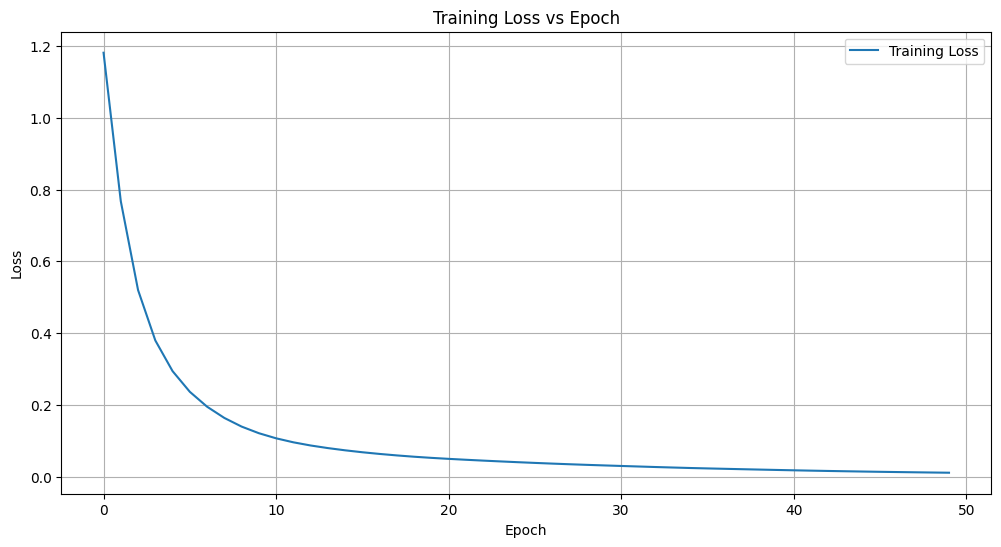

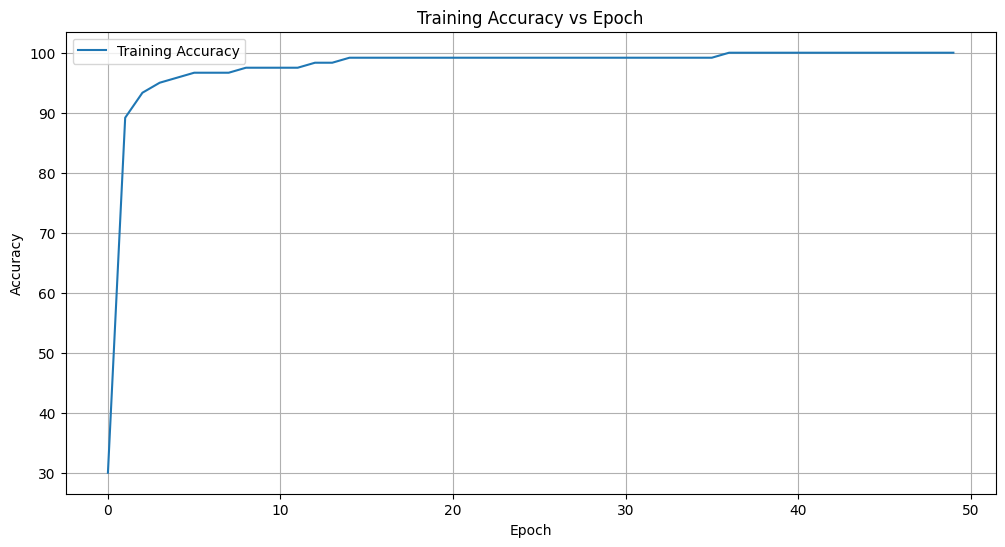

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Define WideResNet for tabular data (adjusted from image version)
class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, num_classes=3):
        super(WideResNet, self).__init__()

        # Calculate number of channels based on depth and widen_factor
        self.num_channels = [16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        self.depth = depth
        self.num_classes = num_classes

        # Define layers for the WideResNet architecture
        self.fc1 = nn.Linear(4, self.num_channels[0])  # 4 input features
        self.fc2 = nn.Linear(self.num_channels[0], self.num_channels[1])
        self.fc3 = nn.Linear(self.num_channels[1], self.num_channels[2])
        self.fc4 = nn.Linear(self.num_channels[2], self.num_classes)

        # Batch normalization
        self.bn1 = nn.BatchNorm1d(self.num_channels[0])
        self.bn2 = nn.BatchNorm1d(self.num_channels[1])
        self.bn3 = nn.BatchNorm1d(self.num_channels[2])

        self.relu = nn.ReLU()

    def forward(self, x):
        # Forward pass through the network
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

# Load and preprocess the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Initialize the model, criterion, and optimizer
model = WideResNet(depth=10, widen_factor=4, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to train the model
def train_model(epochs=50):
    train_losses = []
    train_accs = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y_train_tensor).sum().item()
        accuracy = 100 * correct / len(y_train_tensor)

        train_losses.append(loss.item())
        train_accs.append(accuracy)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')

    return train_losses, train_accs

# Train the model
train_losses, train_accs = train_model(epochs=50)

# Evaluate the model on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_predicted = torch.max(test_outputs, 1)
    test_accuracy = accuracy_score(y_test, test_predicted.numpy())
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Plot loss vs epoch
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy vs epoch
plt.figure(figsize=(12, 6))
plt.plot(train_accs, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()



Running optimization with d0=1e-08
d0=1e-08, Epoch [1/1000], Loss: 1.1228, Accuracy: 32.50%


<ipython-input-13-92fdbdddf4ed>:72: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-13-92fdbdddf4ed>:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enable mixed precision


Streaming output truncated to the last 5000 lines.
d0=0.1, Epoch [9/1000], Loss: 1.0119, Accuracy: 50.00%
d0=0.1, Epoch [10/1000], Loss: 0.9833, Accuracy: 58.33%
d0=0.1, Epoch [11/1000], Loss: 0.9941, Accuracy: 58.33%
d0=0.1, Epoch [12/1000], Loss: 0.9805, Accuracy: 60.83%
d0=0.1, Epoch [13/1000], Loss: 0.9732, Accuracy: 60.83%
d0=0.1, Epoch [14/1000], Loss: 0.9587, Accuracy: 58.33%
d0=0.1, Epoch [15/1000], Loss: 0.9632, Accuracy: 62.50%
d0=0.1, Epoch [16/1000], Loss: 0.9331, Accuracy: 67.50%
d0=0.1, Epoch [17/1000], Loss: 0.9203, Accuracy: 66.67%
d0=0.1, Epoch [18/1000], Loss: 0.9322, Accuracy: 66.67%
d0=0.1, Epoch [19/1000], Loss: 0.9027, Accuracy: 73.33%
d0=0.1, Epoch [20/1000], Loss: 0.9097, Accuracy: 67.50%
d0=0.1, Epoch [21/1000], Loss: 0.9029, Accuracy: 74.17%
d0=0.1, Epoch [22/1000], Loss: 0.8788, Accuracy: 75.00%
d0=0.1, Epoch [23/1000], Loss: 0.8795, Accuracy: 67.50%
d0=0.1, Epoch [24/1000], Loss: 0.8395, Accuracy: 71.67%
d0=0.1, Epoch [25/1000], Loss: 0.8858, Accuracy: 73.33

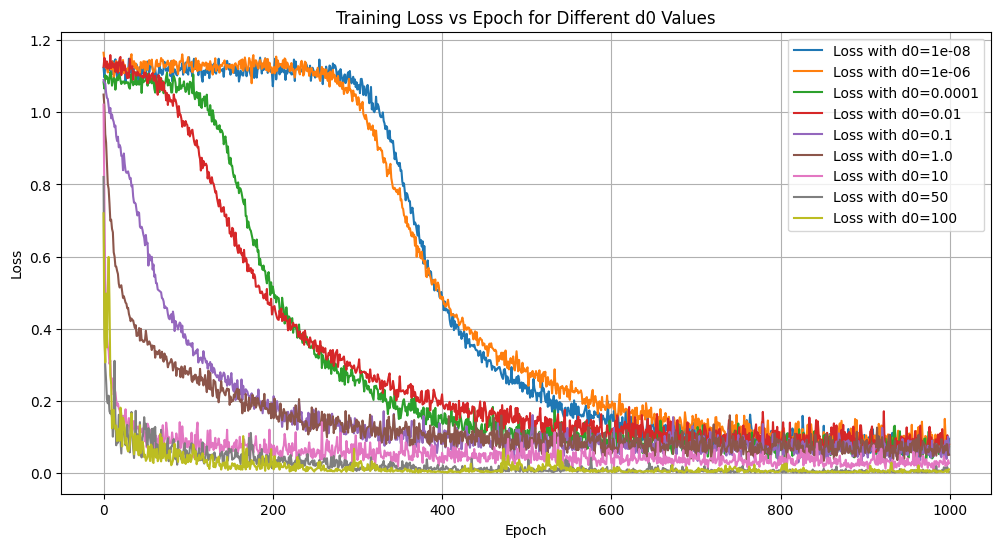

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

# Define available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Iris dataset and split into training and testing
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Custom Dataset for Iris
class IrisDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Prepare DataLoader
train_dataset = IrisDataset(X_train, y_train)
test_dataset = IrisDataset(X_test, y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

# Define a simple WideResNet model for tabular data (modification required from original)
class WideResNet(nn.Module):
    def __init__(self, depth=10, widen_factor=4, num_classes=3):
        super(WideResNet, self).__init__()
        # A simple fully connected WideResNet-like architecture for tabular data
        self.fc1 = nn.Linear(4, 64 * widen_factor)
        self.fc2 = nn.Linear(64 * widen_factor, 128 * widen_factor)
        self.fc3 = nn.Linear(128 * widen_factor, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Criterion
criterion = nn.CrossEntropyLoss()

# Function to train model with specific d0
def train_with_d0(d0, epochs=50):
    model.apply(lambda m: m.reset_parameters() if hasattr(m, "reset_parameters") else None)
    optimizer = DAdaptSGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4, d0=d0)

    scaler = torch.cuda.amp.GradScaler()
    train_losses = []
    train_accs = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():  # Enable mixed precision
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        train_acc = 100 * correct / total

        train_losses.append(avg_loss)
        train_accs.append(train_acc)

        # Print and log training status for each d0
        print(f'd0={d0}, Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {train_acc:.2f}%')

    return train_losses, train_accs

# Run experiments with different d0 values
d0_values = [1e-8, 1e-6, 1e-4, 1e-2, 0.1, 1.0, 10,50,100]
all_train_losses = []
all_train_accs = []

# Initialize the model
model = WideResNet(depth=16, widen_factor=8, num_classes=3).to(device)

for d0 in d0_values:
    print(f"\nRunning optimization with d0={d0}")
    train_losses, train_accs = train_with_d0(d0, epochs=1000)
    all_train_losses.append(train_losses)
    all_train_accs.append(train_accs)

# Plot loss vs epoch for all d0 values
plt.figure(figsize=(12, 6))
for i, d0 in enumerate(d0_values):
    plt.plot(all_train_losses[i], label=f'Loss with d0={d0}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch for Different d0 Values')
plt.legend()
plt.grid(True)
plt.show()





Running optimization with d0=50
d0=50, Epoch [1/500], Loss: 0.8939, Accuracy: 52.50%
d0=50, Epoch [2/500], Loss: 0.4188, Accuracy: 85.83%
d0=50, Epoch [3/500], Loss: 0.3177, Accuracy: 84.17%
d0=50, Epoch [4/500], Loss: 0.2327, Accuracy: 89.17%
d0=50, Epoch [5/500], Loss: 0.2074, Accuracy: 94.17%
d0=50, Epoch [6/500], Loss: 0.1986, Accuracy: 93.33%
d0=50, Epoch [7/500], Loss: 0.1289, Accuracy: 96.67%


<ipython-input-12-ed65b642fa7d>:72: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-12-ed65b642fa7d>:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enable mixed precision


d0=50, Epoch [8/500], Loss: 0.1886, Accuracy: 93.33%
d0=50, Epoch [9/500], Loss: 0.1380, Accuracy: 94.17%
d0=50, Epoch [10/500], Loss: 0.1256, Accuracy: 95.00%
d0=50, Epoch [11/500], Loss: 0.1169, Accuracy: 95.83%
d0=50, Epoch [12/500], Loss: 0.1457, Accuracy: 90.00%
d0=50, Epoch [13/500], Loss: 0.1161, Accuracy: 95.00%
d0=50, Epoch [14/500], Loss: 0.1040, Accuracy: 96.67%
d0=50, Epoch [15/500], Loss: 0.1404, Accuracy: 93.33%
d0=50, Epoch [16/500], Loss: 0.1104, Accuracy: 97.50%
d0=50, Epoch [17/500], Loss: 0.0591, Accuracy: 98.33%
d0=50, Epoch [18/500], Loss: 0.1038, Accuracy: 95.83%
d0=50, Epoch [19/500], Loss: 0.1333, Accuracy: 95.83%
d0=50, Epoch [20/500], Loss: 0.1165, Accuracy: 95.83%
d0=50, Epoch [21/500], Loss: 0.1195, Accuracy: 96.67%
d0=50, Epoch [22/500], Loss: 0.1465, Accuracy: 92.50%
d0=50, Epoch [23/500], Loss: 0.1068, Accuracy: 95.83%
d0=50, Epoch [24/500], Loss: 0.2194, Accuracy: 91.67%
d0=50, Epoch [25/500], Loss: 0.0439, Accuracy: 98.33%
d0=50, Epoch [26/500], Loss: 0

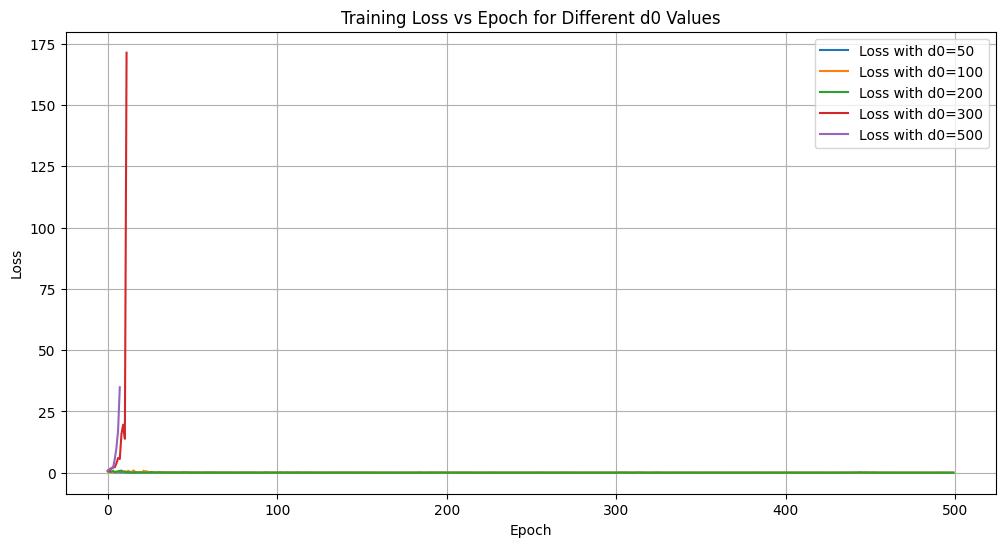

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

# Define available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Iris dataset and split into training and testing
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Custom Dataset for Iris
class IrisDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Prepare DataLoader
train_dataset = IrisDataset(X_train, y_train)
test_dataset = IrisDataset(X_test, y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

# Define a simple WideResNet model for tabular data (modification required from original)
class WideResNet(nn.Module):
    def __init__(self, depth=10, widen_factor=4, num_classes=3):
        super(WideResNet, self).__init__()
        # A simple fully connected WideResNet-like architecture for tabular data
        self.fc1 = nn.Linear(4, 64 * widen_factor)
        self.fc2 = nn.Linear(64 * widen_factor, 128 * widen_factor)
        self.fc3 = nn.Linear(128 * widen_factor, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Criterion
criterion = nn.CrossEntropyLoss()

# Function to train model with specific d0
def train_with_d0(d0, epochs=50):
    model.apply(lambda m: m.reset_parameters() if hasattr(m, "reset_parameters") else None)
    optimizer = DAdaptSGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4, d0=d0)

    scaler = torch.cuda.amp.GradScaler()
    train_losses = []
    train_accs = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():  # Enable mixed precision
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        train_acc = 100 * correct / total

        train_losses.append(avg_loss)
        train_accs.append(train_acc)

        # Print and log training status for each d0
        print(f'd0={d0}, Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {train_acc:.2f}%')

    return train_losses, train_accs

# Run experiments with different d0 values
d0_values = [50,100,200,300,500]
all_train_losses = []
all_train_accs = []

# Initialize the model
model = WideResNet(depth=16, widen_factor=8, num_classes=3).to(device)

for d0 in d0_values:
    print(f"\nRunning optimization with d0={d0}")
    train_losses, train_accs = train_with_d0(d0, epochs=500)
    all_train_losses.append(train_losses)
    all_train_accs.append(train_accs)

# Plot loss vs epoch for all d0 values
plt.figure(figsize=(12, 6))
for i, d0 in enumerate(d0_values):
    plt.plot(all_train_losses[i], label=f'Loss with d0={d0}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch for Different d0 Values')
plt.legend()
plt.grid(True)
plt.show()


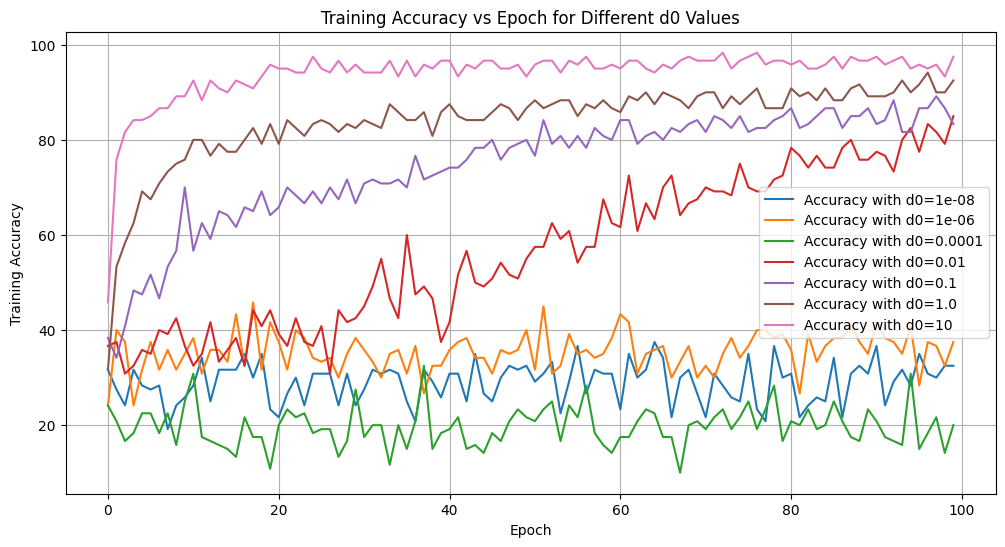

In [9]:
# Plot accuracy vs epoch for all d0 values
plt.figure(figsize=(12, 6))
for i, d0 in enumerate(d0_values):
    plt.plot(all_train_accs[i], label=f'Accuracy with d0={d0}')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs Epoch for Different d0 Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transforms for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

# Define a WideResNet model adapted for CIFAR-10
class WideResNet(nn.Module):
    def __init__(self, depth=10, widen_factor=4, num_classes=10):
        super(WideResNet, self).__init__()
        # Define a simplified WideResNet-like structure for CIFAR-10
        self.conv1 = nn.Conv2d(3, 64 * widen_factor, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64 * widen_factor, 128 * widen_factor, kernel_size=3, padding=1)
        self.fc = nn.Linear(128 * widen_factor * 8 * 8, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Initialize the model
model = WideResNet().to(device)

# Criterion
criterion = nn.CrossEntropyLoss()

# Function to train model with specific d0
def train_with_d0(d0, epochs=50):
    model.apply(lambda m: m.reset_parameters() if hasattr(m, "reset_parameters") else None)
    optimizer = DAdaptSGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4, d0=d0)

    scaler = torch.cuda.amp.GradScaler()
    train_losses = []
    train_accs = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():  # Enable mixed precision
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        train_acc = 100 * correct / total

        train_losses.append(avg_loss)
        train_accs.append(train_acc)

        # Print and log training status for each d0
        print(f'd0={d0}, Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {train_acc:.2f}%')

    return train_losses, train_accs

# Run experiments with different d0 values
d0_values = [1e-8, 1e-6, 1e-4, 1e-2, 0.1, 1.0, 10, 50, 100]
all_train_losses = []
all_train_accs = []

for d0 in d0_values:
    print(f"\nRunning optimization with d0={d0}")
    train_losses, train_accs = train_with_d0(d0, epochs=100)
    all_train_losses.append(train_losses)
    all_train_accs.append(train_accs)

# Plot loss vs epoch for all d0 values
plt.figure(figsize=(12, 6))
for i, d0 in enumerate(d0_values):
    plt.plot(all_train_losses[i], label=f'Loss with d0={d0}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch for Different d0 Values')
plt.legend()
plt.grid(True)
plt.show()


Files already downloaded and verified
Files already downloaded and verified

Running optimization with d0=1e-08


<ipython-input-15-6adff8155ee9>:59: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-15-6adff8155ee9>:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enable mixed precision


d0=1e-08, Epoch [1/100], Loss: 2.3224, Accuracy: 9.58%
d0=1e-08, Epoch [2/100], Loss: 2.3210, Accuracy: 9.64%
d0=1e-08, Epoch [3/100], Loss: 2.3224, Accuracy: 9.63%
d0=1e-08, Epoch [4/100], Loss: 2.3215, Accuracy: 9.68%
d0=1e-08, Epoch [5/100], Loss: 2.3214, Accuracy: 9.68%
d0=1e-08, Epoch [6/100], Loss: 2.3203, Accuracy: 9.79%
d0=1e-08, Epoch [7/100], Loss: 2.3202, Accuracy: 9.85%
d0=1e-08, Epoch [8/100], Loss: 2.3211, Accuracy: 9.60%
d0=1e-08, Epoch [9/100], Loss: 2.3221, Accuracy: 9.50%
d0=1e-08, Epoch [10/100], Loss: 2.3197, Accuracy: 9.75%
d0=1e-08, Epoch [11/100], Loss: 2.3149, Accuracy: 9.98%
d0=1e-08, Epoch [12/100], Loss: 2.3046, Accuracy: 10.64%
d0=1e-08, Epoch [13/100], Loss: 2.2848, Accuracy: 12.86%
d0=1e-08, Epoch [14/100], Loss: 2.2476, Accuracy: 17.07%
d0=1e-08, Epoch [15/100], Loss: 2.1869, Accuracy: 22.00%
d0=1e-08, Epoch [16/100], Loss: 2.1015, Accuracy: 26.82%
d0=1e-08, Epoch [17/100], Loss: 2.0074, Accuracy: 30.54%
d0=1e-08, Epoch [18/100], Loss: 1.9217, Accuracy: 3